In [ ]:
library(tidyverse)
library(ggplot2)
library(ggthemes)
library(patchwork)
library(ggsci)
library(ggvenn)
library(ComplexHeatmap)
library(RColorBrewer)
library(ggbeeswarm)
library(tidyr)
library(circlize)
library(fastcluster)
library(ggrepel)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformati

In [ ]:
setwd("/data/wuqinhua/scPhase/COVID")

## 1. Attribution score top20 gene

In [ ]:
covid_H = read.table('./ensemble_gene_attributions_H.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_H <- covid_H[order(covid_H$mean_attribution, decreasing = TRUE),]
H_top20 <- covid_H[1:20, ] # nolint
colors <- colorRampPalette(c("#B3EE3A","#006400"))(20)#
p1 = ggplot(H_top20, mapping = aes(x = reorder(gene,mean_attribution), y = mean_attribution)) +
  geom_bar(stat = 'identity',fill=colors,width=0.78,position =position_dodge(0.7)) + # nolint
  labs(x= " ",y="Covid19_H Attribution Score", fill = "gene",size=8,family = "sans", face = "bold.italic") +
  coord_flip()+ # nolint
  # geom_text(aes(label = sprintf("%.3f",mean_attribution)),size =3,hjust = ifelse(H_top20$mean_attribution < 0,0,1))+
  scale_fill_manual(name = "Gene",values = colors) +
  theme_classic() +
  theme(axis.text = element_text(family = "sans",size = 11, face = "bold.italic"))
#ggsave('./plot/top20_H.png',p1,width =6,height=8)

covid_M = read.table('./ensemble_gene_attributions_M.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_M <- covid_M[order(covid_M$mean_attribution, decreasing = TRUE),]
M_top20 <- covid_M[1:20, ]
colors <- colorRampPalette(c("#87CEFA","#1C86EE"))(20)#
p2 <- ggplot(M_top20, mapping = aes(x = reorder(gene,mean_attribution), y = mean_attribution)) +
  geom_bar(stat = 'identity',fill=colors,width=0.78,position =position_dodge(0.7)) +
  labs(x= " ",y="Covid19_M Attribution Score", fill = "gene",size=8,family = "sans", face = "bold.italic") +
  coord_flip()+
  # geom_text(aes(label = sprintf("%.3f",mean_attribution)),size =3,hjust = ifelse(M_top20$mean_attribution < 0,0,1))+
  scale_fill_manual(name = "Gene",values = colors) +
  theme_classic() +
  theme(axis.text = element_text(family = "sans",size = 11, face = "bold.italic")) # nolint: line_length_linter.
#ggsave('./plot/top20_M.png',p2,width =6,height=8)

covid_S = read.table('./ensemble_gene_attributions_S.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)

covid_S <- covid_S[order(covid_S$mean_attribution, decreasing = TRUE),]
S_top20 <- covid_S[1:20, ]
colors <- colorRampPalette(c("#FFD700","#EE7942"))(20)#
p3 <- ggplot(S_top20, mapping = aes(x = reorder(gene,mean_attribution), y = mean_attribution)) +
  geom_bar(stat = 'identity',fill=colors,width=0.78,position =position_dodge(0.7)) +
  labs(x= " ",y="Covid19_S Attribution Score", fill = "gene",size=8,family = "sans", face = "bold.italic") +
  coord_flip()+
  # geom_text(aes(label = sprintf("%.3f",mean_attribution)),size =3,hjust = ifelse(S_top20$mean_attribution < 0,0,1))+ # nolint: commas_linter.
  scale_fill_manual(name = "Gene",values = colors) +
  theme_classic() +
  theme(axis.text = element_text(family = "sans",size = 11, face = "bold.italic")) # nolint
#ggsave('./plot/top20_S.png',p3,width =6,height=8)

p = p1+p2+p3
ggsave('./Analysis/Figure/Attr_plot/top20_all_COVID.pdf',p,width =18,height=8)

In [ ]:
covid_H = read.table('./ensemble_gene_attributions_H.csv', header = TRUE, sep = ',', stringsAsFactors = FALSE)
covid_H$consistency <- covid_H$mean_attribution / (covid_H$std_attribution + 1e-8)

covid_M = read.table('./ensemble_gene_attributions_M.csv', header = TRUE, sep = ',', stringsAsFactors = FALSE)
covid_M$consistency <- covid_M$mean_attribution / (covid_M$std_attribution + 1e-8)

covid_S = read.table('./ensemble_gene_attributions_S.csv', header = TRUE, sep = ',', stringsAsFactors = FALSE)
covid_S$consistency <- covid_S$mean_attribution / (covid_S$std_attribution + 1e-8)

H_top20 <- covid_H[order(covid_H$mean_attribution, decreasing = TRUE),][1:20, ]
M_top20 <- covid_M[order(covid_M$mean_attribution, decreasing = TRUE),][1:20, ]
S_top20 <- covid_S[order(covid_S$mean_attribution, decreasing = TRUE),][1:20, ]


bubble_H <- ggplot(H_top20, aes(x = consistency, y = mean_attribution)) +
  geom_point(aes(size = abs(mean_attribution), color = consistency), alpha = 0.8) +
  geom_text_repel(aes(label = gene), 
                  size = 2.8, 
                  color = "black",
                  box.padding = 0.5,
                  point.padding = 0.3,
                  segment.color = "grey50",
                  segment.size = 0.3,
                  max.overlaps = Inf) +
  labs(x = "Consistency (Mean/Std)", 
       y = "Mean Attribution Score", 
       title = "Covid19_H: Top20 Genes",
       size = "Attribution\nMagnitude",
       color = "Consistency") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
        axis.text = element_text(family = "sans", size = 9),
        axis.title = element_text(family = "sans", size = 10, face = "bold"),
        legend.position = "bottom",
        legend.box = "horizontal",
        legend.key.size = unit(0.4, "cm"),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 9)) +
  scale_color_gradient(low = "#B3EE3A", high = "#006400", name = "Consistency") +
  scale_size_continuous(range = c(4, 12), name = "Attribution\nMagnitude") +
  guides(color = guide_colorbar(title.position = "top", title.hjust = 0.5),
         size = guide_legend(title.position = "top", title.hjust = 0.5))

bubble_M <- ggplot(M_top20, aes(x = consistency, y = mean_attribution)) +
  geom_point(aes(size = abs(mean_attribution), color = consistency), alpha = 0.8) +
  geom_text_repel(aes(label = gene), 
                  size = 2.8, 
                  color = "black",
                  box.padding = 0.5,
                  point.padding = 0.3,
                  segment.color = "grey50",
                  segment.size = 0.3,
                  max.overlaps = Inf) +
  labs(x = "Consistency (Mean/Std)", 
       y = "Mean Attribution Score", 
       title = "Covid19_M: Top20 Genes",
       size = "Attribution\nMagnitude",
       color = "Consistency") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
        axis.text = element_text(family = "sans", size = 9),
        axis.title = element_text(family = "sans", size = 10, face = "bold"),
        legend.position = "bottom",
        legend.box = "horizontal",
        legend.key.size = unit(0.4, "cm"),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 9)) +
  scale_color_gradient(low = "#87CEFA", high = "#1C86EE", name = "Consistency") +
  scale_size_continuous(range = c(4, 12), name = "Attribution\nMagnitude") +
  guides(color = guide_colorbar(title.position = "top", title.hjust = 0.5),
         size = guide_legend(title.position = "top", title.hjust = 0.5))

bubble_S <- ggplot(S_top20, aes(x = consistency, y = mean_attribution)) +
  geom_point(aes(size = abs(mean_attribution), color = consistency), alpha = 0.8) +
  geom_text_repel(aes(label = gene), 
                  size = 2.8, 
                  color = "black",
                  box.padding = 0.5,
                  point.padding = 0.3,
                  segment.color = "grey50",
                  segment.size = 0.3,
                  max.overlaps = Inf) +
  labs(x = "Consistency (Mean/Std)", 
       y = "Mean Attribution Score", 
       title = "Covid19_S: Top20 Genes",
       size = "Attribution\nMagnitude",
       color = "Consistency") +
  theme_classic() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
        axis.text = element_text(family = "sans", size = 9),
        axis.title = element_text(family = "sans", size = 10, face = "bold"),
        legend.position = "bottom",
        legend.box = "horizontal",
        legend.key.size = unit(0.4, "cm"),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 9)) +
  scale_color_gradient(low = "#FFD700", high = "#EE7942", name = "Consistency") +
  scale_size_continuous(range = c(4, 12), name = "Attribution\nMagnitude") +
  guides(color = guide_colorbar(title.position = "top", title.hjust = 0.5),
         size = guide_legend(title.position = "top", title.hjust = 0.5))

bubble_combined <- bubble_H + bubble_M + bubble_S

ggsave('./Analysis/Figure/Attr_plot//bubble_plot_optimized_COVID.pdf', 
       bubble_combined, 
       width = 15, 
       height = 8,
       device = "pdf")



## 2. venn plot of H-M-S

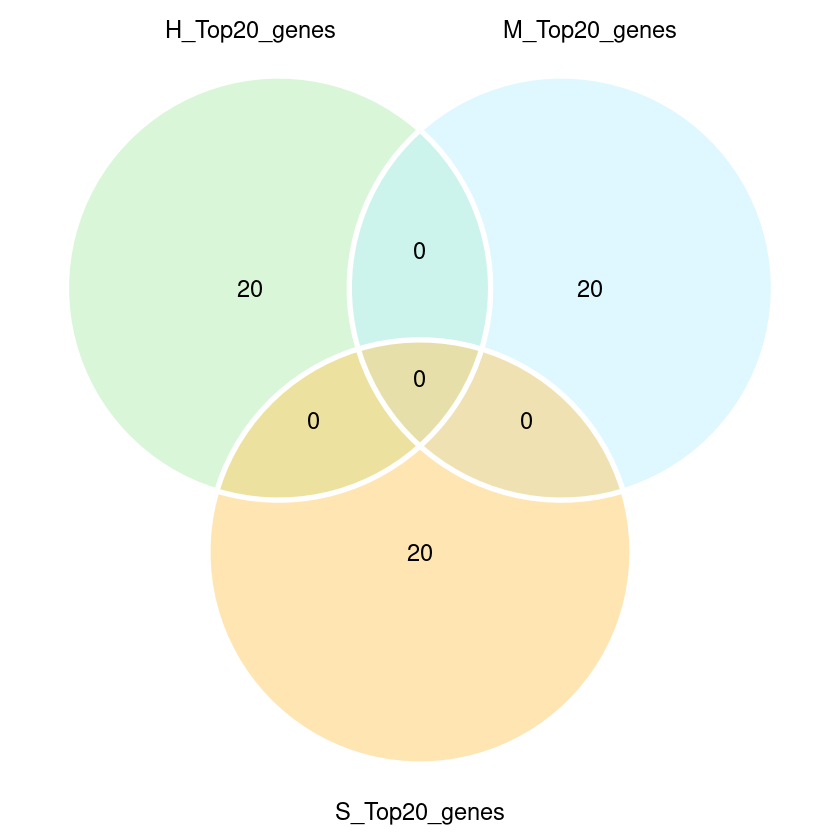

In [ ]:
covid_H = read.table('./ensemble_gene_attributions_H.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_H <- covid_H[order(covid_H$mean_attribution, decreasing = TRUE),]
H_genes <- covid_H[1:20, 1]
covid_M = read.table('./ensemble_gene_attributions_M.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_M <- covid_M[order(covid_M$mean_attribution, decreasing = TRUE),]
M_genes <- covid_M[1:20, 1]
covid_S = read.table('./ensemble_gene_attributions_S.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_S <- covid_S[order(covid_S$mean_attribution, decreasing = TRUE),]
S_genes <- covid_S[1:20, 1]
dat = list(H_Top20_genes=H_genes, M_Top20_genes=M_genes, S_Top20_genes=S_genes)
p1 <- ggvenn(dat,show_percentage = F,stroke_color = "white",stroke_size = 1.5,
             fill_color = c("#B4EEB4", "#BFEFFF", "#FFCC66"),
             set_name_size = 5,text_size=5)
p1
ggsave("./Analysis/Figure/ggvenn_top20.pdf", p1, width=5, height=5)

unique_H_genes <- setdiff(H_genes, c(M_genes, S_genes))
unique_M_genes <- setdiff(M_genes, c(H_genes, S_genes))
unique_S_genes <- setdiff(S_genes, c(H_genes, M_genes))

max_length <- max(length(unique_H_genes), length(unique_M_genes), length(unique_S_genes))
unique_H_genes <- c(unique_H_genes, rep(NA, max_length - length(unique_H_genes)))
unique_M_genes <- c(unique_M_genes, rep(NA, max_length - length(unique_M_genes)))
unique_S_genes <- c(unique_S_genes, rep(NA, max_length - length(unique_S_genes)))

gene_unique <- data.frame(H=unique_H_genes, M=unique_M_genes, S=unique_S_genes)
write.csv(gene_unique, file = "./Analysis/Figure/Attr_plot/unique_Topgenes_venn.csv", row.names = FALSE)


## 3. Heatmap of top20 gene attribution score

In [ ]:
covid_H = read.table('./ensemble_gene_attributions_H.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_H <- covid_H[order(covid_H$mean_attribution, decreasing = TRUE),]
H_genes <- covid_H[1:20, ]
covid_M = read.table('./ensemble_gene_attributions_M.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_M <- covid_M[order(covid_M$mean_attribution, decreasing = TRUE),]
M_genes <- covid_M[1:20, ]
covid_S = read.table('./ensemble_gene_attributions_S.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_S <- covid_S[order(covid_S$mean_attribution, decreasing = TRUE),]
S_genes <- covid_S[1:20, ]
combined_genes <- union(union(H_genes$gene, M_genes$gene), S_genes$gene)
unique_genes <- unique(combined_genes)

data = read.csv('./sample_gene_attribution_mean.csv',row.names = 1)
selected_columns <- names(data) %in% unique_genes
all_top20 = data[, selected_columns, drop = FALSE]
all_top20 = as.matrix(all_top20)
all_top20 <- apply(all_top20, 2, function(x) (x - min(x)) / (max(x) - min(x)))
all_top20

condition = read.csv('./COVID19_sample_condition_560.csv')
rownames(condition) <- gsub("\\.", "_", rownames(condition))
dict1 <- setNames(condition$group, condition$sample_id)
dict2 <- setNames(condition$Source, condition$sample_id)

group = c()
dataset = c()
for (i in seq_along(row.names(all_top20))){
  row_name <- row.names(all_top20)[i]
  g <- dict1[row_name]
  group[i] <- g
  d <- dict2[row_name]
  dataset[i] <- d
  }
df <- data.frame(group, dataset)
expData = t(scale(t(all_top20)))
expData = pmax(pmin(expData,2),-2)

col_fun = colorRamp2(c(-2,-1,0,1,2),rev(brewer.pal(n = 5, name = "RdBu")))

left_ha = rowAnnotation(Cluster = df$group,Dataset = df$dataset, simple_anno_size = unit(8,'points'),
                        col = list(Cluster = c("H" = '#66DD00',"M"="#77DDFF","S"="#FFBB66"),
                                   Dataset = c("Arunachalam_2020"="#377EB8","COMBAT_2022"="darkorchid1","Combes_2021"="#A6D854",
                                               "Liu_2021"="#66C2A5","Ren_2021"="#0000C6","Schulte-Schrepping_2020"="khaki2",
                                               "Schuurman_2021"="#4DAF4A","Stephenson_2021"="#999999","Unterman_2022"="#984EA3",
                                               "Wilk_2021"="#E5C494","Zhao_2021"="#E41A1C","Zhu_2020"="#8DA0CB")),
                        show_annotation_name = F)

fh = function(x) fastcluster::hclust(dist(x),"ave")

pdf('./Analysis/Figure/Attr_plot/heatmap_attr_ave.pdf',width = 6,height = 6)
Heatmap(expData,
        show_row_names = F,show_column_names = F,
        show_row_dend = T,show_column_dend = T,
        cluster_rows = fh,cluster_columns = fh,
        col = col_fun,
        row_title = NULL,column_title = NULL,
        heatmap_legend_param = list(title = ''),
        top_annotation = NULL,
        left_annotation = left_ha,
        right_annotation = NULL,
        use_raster = TRUE, raster_quality = 2)
dev.off()

,AIF1,ATF7IP,ATM,CCL5,CD247,CD3D,CD69,CD74,CLU,COTL1,⋯,SAT1,SORL1,SP110,TALDO1,TNFRSF1B,TPM4,TSPO,TUBA1B,TYROBP,XAF1
563,0.7427490,0.7585647,0.4249155,0.8066567,0.5982510,0.5706628,0.39524021,0.5568550,0.3717334,0.5043898,⋯,0.6783369,0.4377871,0.8272425,0.3337954,0.17560355,0.30178571,0.5026273,0.4575418,0.7083785,0.5530006
564_B,0.7936726,0.4317840,0.8334849,0.8266507,0.5292874,0.6763198,0.41991545,0.6203346,0.2661051,0.4612035,⋯,0.5935269,0.3072992,0.6852690,0.3545231,0.50447900,0.16712427,0.3367159,0.4135983,0.6246350,0.6468958
565,0.6720706,0.8158675,0.3285251,0.7706742,0.5823781,0.5627656,0.35700980,0.5737783,0.4249367,0.5197437,⋯,0.7061538,0.5566804,0.7317414,0.3397604,0.14724771,0.21330909,0.5464963,0.4522065,0.6782025,0.6552689
566,0.7189185,0.7546733,0.4588329,0.7999581,0.6599847,0.5875497,0.37925256,0.5717637,0.4823958,0.5477697,⋯,0.6788238,0.4564140,0.7010460,0.3721177,0.18693897,0.23277916,0.4748345,0.4610538,0.6514826,0.4952879
568_PBMC,0.8254823,0.4107569,0.7473696,0.8491433,0.5175340,0.6633087,0.42362250,0.6454713,0.3705654,0.5243123,⋯,0.5042406,0.4385207,0.7900962,0.3032641,0.54382844,0.29716215,0.3386648,0.4200075,0.5108848,0.6599216
569_PBMC,0.7327955,0.4471592,0.8258392,0.8986374,0.5265687,0.6740709,0.42014758,0.6473431,0.3534625,0.4838474,⋯,0.5182394,0.3361664,0.7818962,0.3546733,0.50661828,0.24846003,0.3091076,0.4227788,0.5163982,0.6354337
570_PBMC,0.8283691,0.3897371,0.7098561,0.8379575,0.4962614,0.6712896,0.41847118,0.6607764,0.4046016,0.5325142,⋯,0.5372021,0.3560433,0.8215251,0.3579881,0.47408558,0.39253554,0.3370455,0.4109279,0.5594419,0.6624951
AA220014_HC,0.4266702,0.6005987,0.6887535,0.9247042,0.3533170,0.7424014,0.60104199,1.0000000,0.3320065,0.6476438,⋯,0.7728180,0.2166122,0.8700786,0.8531437,0.07054017,0.15545048,0.1396355,0.3838961,0.3196656,0.5388484
AA220534_HC,0.6220474,0.6463732,0.7525284,0.9105926,0.2896750,0.8395291,0.65024667,0.8575952,0.3319792,0.6791231,⋯,0.7794026,0.2277420,0.8838630,0.8473061,0.06791837,0.16280901,0.2782277,0.2972171,0.3923058,0.4460750
AA220907_HC,0.6208655,0.6134175,0.7271664,0.9269679,0.3754279,0.7890962,0.72035513,0.8683904,0.3345456,0.7308678,⋯,0.7426621,0.2262270,0.8400845,0.8602908,0.13020139,0.19314567,0.2518527,0.3590052,0.3719833,0.5242001


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

## 4. Heatmap of top20 gene expression level

In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse
os.chdir("/data/wuqinhua/scPhase/COVID")


In [ ]:
sce = sc.read_h5ad("./ensemble_adata_with_attention.h5ad")
raw_matrix = sce.raw.X.tocsr() if not scipy.sparse.isspmatrix_csr(sce.raw.X) else sce.raw.X
raw_df = pd.DataFrame.sparse.from_spmatrix(
        raw_matrix,
        index=sce.obs_names,      
        columns=sce.raw.var_names  
)

In [ ]:
raw_df['sample_id'] = sce.obs['sample_id'].values
sample_gene_expression = raw_df.groupby('sample_id').sum()
hvg_genes = sce.var[sce.var['highly_variable']].index.tolist()
hvg_df = sample_gene_expression[hvg_genes]
hvg_df.to_csv("./exp_sample_COVID.csv")

In [1]:
library(tidyverse)
library(ggplot2)
library(ggthemes)
library(patchwork)
library(ggsci)
library(ggvenn)
library(ComplexHeatmap)
library(RColorBrewer)
library(ggbeeswarm)
library(tidyr)
library(circlize)
library(fastcluster)

setwd("/data/wuqinhua/scPhase/COVID")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformati

In [5]:
covid_H = read.table('./ensemble_gene_attributions_H.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_H <- covid_H[order(covid_H$mean_attribution, decreasing = TRUE),]
H_genes <- covid_H[1:20, 1]
covid_M = read.table('./ensemble_gene_attributions_M.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_M <- covid_M[order(covid_M$mean_attribution, decreasing = TRUE),]
M_genes <- covid_M[1:20, 1]
covid_S = read.table('./ensemble_gene_attributions_S.csv', header = TRUE,  sep = ',',  stringsAsFactors = FALSE)
covid_S <- covid_S[order(covid_S$mean_attribution, decreasing = TRUE),]
S_genes <- covid_S[1:20, 1]

In [7]:
combined_genes <- union(union(H_genes, M_genes), S_genes)
unique_genes <- unique(combined_genes)
data = read.csv('./exp_sample_COVID.csv',row.names = 1)
selected_columns <- names(data) %in% unique_genes
all_top20 = data[, selected_columns, drop = FALSE]
all_top20 = as.matrix(all_top20)
all_top20 <- apply(all_top20, 2, function(x) (x - min(x)) / (max(x) - min(x)))
all_top20

condition = read.csv('./COVID19_sample_condition_560.csv')  
rownames(condition) <- gsub("\\.", "_", rownames(condition))
dict1 <- setNames(condition$group, condition$sample_id)
dict2 <- setNames(condition$Source, condition$sample_id)

group = c()
dataset = c()
for (i in seq_along(row.names(all_top20))){
  row_name <- row.names(all_top20)[i]
  g <- dict1[row_name]
  group[i] <- g
  d <- dict2[row_name]
  dataset[i] <- d
  }
df <- data.frame(group, dataset)

expData = t(scale(t(all_top20)))
expData = pmax(pmin(expData,2),-2)

col_fun = colorRamp2(c(-2,-1,0,1,2),rev(brewer.pal(n = 5, name = "RdBu")))

left_ha = rowAnnotation(Cluster = df$group,Dataset = df$dataset, simple_anno_size = unit(8,'points'),
                        col = list(Cluster = c("H" = '#66DD00',"M"="#77DDFF","S"="#FFBB66"),
                                   Dataset = c("Arunachalam_2020"="#377EB8","COMBAT_2022"="darkorchid1","Combes_2021"="#A6D854",
                                               "Liu_2021"="#66C2A5","Ren_2021"="#0000C6","Schulte-Schrepping_2020"="khaki2",
                                               "Schuurman_2021"="#4DAF4A","Stephenson_2021"="#999999","Unterman_2022"="#984EA3",
                                               "Wilk_2021"="#E5C494","Zhao_2021"="#E41A1C","Zhu_2020"="#8DA0CB")),
                        show_annotation_name = F)

fh = function(x) fastcluster::hclust(dist(x),"ave")

pdf('./Analysis/Figure/Attr_plot/heatmap_exp_ave.pdf',width = 6,height = 6)
Heatmap(expData,
        show_row_names = F,show_column_names = F,
        show_row_dend = T,show_column_dend = T,
        cluster_rows = fh,cluster_columns = fh,
        col = col_fun,
        row_title = NULL,column_title = NULL,
        heatmap_legend_param = list(title = ''),
        top_annotation = NULL,
        left_annotation = left_ha,
        right_annotation = NULL,
        use_raster = TRUE, raster_quality = 2)
dev.off()

,AIF1,ATF7IP,ATM,CCL5,CD247,CD3D,CD69,CD74,CLU,COTL1,⋯,SAT1,SORL1,SP110,TALDO1,TNFRSF1B,TPM4,TSPO,TUBA1B,TYROBP,XAF1
563,0.026811832,0.16327888,0.27498388,0.04457717,0.14374537,0.07166508,0.01677029,0.02138749,0.018313491,0.02955831,⋯,0.03341758,0.137166529,0.08627165,0.05752544,0.084356501,0.12729280,0.03895048,0.006406180,0.037628685,0.179847613
564_B,0.010187141,0.06819909,0.11492585,0.03569097,0.04529978,0.02321598,0.00534767,0.01432288,0.012208994,0.02410792,⋯,0.01664879,0.064291632,0.03635510,0.04500905,0.052510414,0.07109993,0.02320454,0.003497170,0.015397611,0.021365262
565,0.076132501,0.33795593,0.60761874,0.13112023,0.26518628,0.13044719,0.03500228,0.05161272,0.090088724,0.09618146,⋯,0.09060843,0.301043911,0.17718548,0.14535864,0.232542206,0.20311637,0.11103467,0.010539200,0.117865213,0.414772197
566,0.045955073,0.27992021,0.43826564,0.06592550,0.36308907,0.07678402,0.02747989,0.03001220,0.097634034,0.05076153,⋯,0.05582595,0.190521955,0.22449405,0.09551158,0.201381276,0.24378872,0.07230310,0.012414955,0.088100160,0.794744208
568_PBMC,0.047773398,0.13506839,0.17381259,0.02903606,0.05970886,0.03569933,0.01385403,0.02936449,0.094486995,0.07690383,⋯,0.13838747,0.240397680,0.06738994,0.12288532,0.128398378,0.34470278,0.08554720,0.009029058,0.067270118,0.036510652
569_PBMC,0.079780446,0.23518237,0.28315066,0.02501194,0.11241056,0.05463368,0.01991472,0.03915767,0.360961553,0.11573107,⋯,0.10022273,0.249179785,0.13420613,0.20906424,0.259153694,0.30255813,0.13395775,0.010777644,0.121841670,0.193717929
570_PBMC,0.067628158,0.23641717,0.21894477,0.04988746,0.10569948,0.03684110,0.01803947,0.02468201,0.221088951,0.10472150,⋯,0.13897242,0.392046396,0.09159190,0.24960984,0.190775049,0.51340409,0.19090582,0.013734342,0.099837233,0.057782615
AA220014_HC,0.194086489,0.07418313,0.05582420,0.09934620,0.13155687,0.02774500,0.02340140,0.20607862,0.003222871,0.25437337,⋯,0.13172795,0.031847556,0.09044440,0.16620888,0.123383030,0.08637507,0.18755961,0.068353786,0.226884696,0.026061266
AA220534_HC,0.072021504,0.05775076,0.04647539,0.16589529,0.11566741,0.05147479,0.02245308,0.10576251,0.001933723,0.10354656,⋯,0.06331791,0.017431649,0.06269560,0.07160247,0.059389388,0.05692902,0.07325692,0.048896802,0.093917188,0.027522936
AA220907_HC,0.064770789,0.05005699,0.04040404,0.05151465,0.06701209,0.02713606,0.02951201,0.14228198,0.003222871,0.09255875,⋯,0.04900895,0.016139188,0.05982683,0.08243336,0.044781846,0.04889271,0.07028599,0.036688497,0.087447719,0.016233867


'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2